This notebook makes Figure 1(b) from Protheroe & Biermann (1996; https://arxiv.org/pdf/astro-ph/9605119.pdf). This figure shows the expected radio spectra for a nearby (star-forming) galaxy which experiences both internal free-free absorption and synchrotron self-absorption.

There are two stages to the notebook:

1. An annotated guide to the steps in the calculation;
2. Code to reproduce Fig 1(b) exactly. 

---

In [1]:
import numpy as np
import pylab as pl

from pacholcsyk import *
import freefree as ff

In [ ]:
pc2cm = 3.086e18   # pc --> cm

To start with we can define a few parameters of the galaxy. 

- We'll model it as a solid disk with height 1kpc and a radius of 15kpc. 

- We'll assume a galactic magnetic field strength of 6 $\mu$G.

- We'll assume a thermal electron density of 0.01 cm$^{-3}$

- We'll assume a thermal electron temperature of $3\times 10^5$ K.

In [2]:
gal_radius_kpc = 15.
gal_height_kpc = 1.
H_G = 6e-6				# [G] = 6 uGauss  [CGS units]
H_T = H_G*1e-4          # T  [SI units]
ne_cm = 0.01			# cm^-3	[CGS units]
Te = 3e5				# [K]
N0 = 5e-10				# what should this be..? [m^-3 MeV^-1]

First set the range of frequencies:

In [3]:
nu = 10**np.arange(3,12,0.1)  # 1 kHz -> 10 GHz

The emissivity (in CGS units) is given by:

$$
\epsilon_{\nu} = \frac{1}{2}c_3 B \sin \theta \int_0^{\infty}{ N(E) F(x) {\rm d}E }
$$

We're going to use the equations from Pacholcsyk. The code for these can be found in the accompanying module pacholcsyk.py.

In [4]:
em_nu = calc_em_synch(nu,H_G,N0)

integrals.py:15: RuntimeWarning: divide by zero encountered in log
  return quad(lambda x,*args: np.exp(x + np.log(func(np.exp(x),*args))), np.log(a), np.log(b), **kwargs)


Then the synchrotron absorption co-efficient,

$$
\kappa_{\nu} = -\frac{c^2c_3}{2\nu^2} B \sin \theta \int_0^{\infty}{E^2 \frac{\rm d}{{\rm d}E} \left[\frac{N(E)}{E^2}\right] F(x) {\rm d}E }
$$

(in CGS units).

In [5]:
kappa_nu = calc_kappa_synch(nu,H_G,N0)

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


Then the free-free absorption co-efficient,

In [6]:
kappa_ff = ff.calc_kappa_ff(nu,ne_cm,Te)/pc2cm  # cm^-1

So the total absorption per unit line of sight is the sum of these two quantities:

In [7]:
kappa = kappa_ff+kappa_nu

If we combine this with the expected path length through our model nearby galaxy (calculated using $<\sin \theta> = 0.785$) we can find the total optical depth:

In [8]:
dl = 1.61*gal_height_kpc*1000.*pc2cm
tau = kappa*dl

We can then compute the full equation of radiative transfer,

$$
I_{\nu} = S_{\nu}\left( 1 - {\rm e}^{-\tau_{\nu}} \right)
$$

where,

$$
S_{\nu} = \frac{\epsilon_{\nu}}{\kappa_{\nu}}
$$



In [9]:
i_nu = (em_nu/kappa)*(1 - np.exp(-1.*tau))

We're going to compare the absorption limit with Longair's approximation. This is calculated in SI units:

In [10]:
dr = gal_radius_kpc*1000.*pc2cm/100. # metres [SI units]
A_m2 = np.pi*dr**2

L_abs = L_abs_ML(nu, H_T, A_m2)
L_nu = i_nu*1e-3*4*np.pi*A_m2	# 1e-3 for conversion: erg/s/cm^2/Hz ---> Watts/m^2/Hz

Let's plot that up:

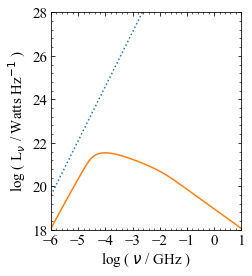

In [11]:
from matplotlib.ticker import AutoMinorLocator
from matplotlib import rcParams

rcParams['font.sans-serif'] = "Times New Roman"
rcParams['font.family'] = "sans-serif"

ax = pl.subplot(111)

pl.plot(np.log10(nu/1e9), np.log10(L_abs), ls=":")
pl.plot(np.log10(nu/1e9), np.log10(L_nu)) 

pl.axis([-6,1,18,28])
pl.xlabel(r"log ( $\nu$ / GHz )",size=15)
pl.ylabel(r"log ( L$_{\nu}$ / Watts Hz$^{-1}$ )",size=15)
pl.locator_params(axis='x', nbins=8)
pl.locator_params(axis='y', nbins=5)
ax.tick_params(which="both",direction="in",top=True,right=True,labelsize=15)
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.set_aspect(0.8)

rcParams['figure.figsize'] = [10, 10]
pl.show()

To make the Fig 1(b) plot we need to loop:

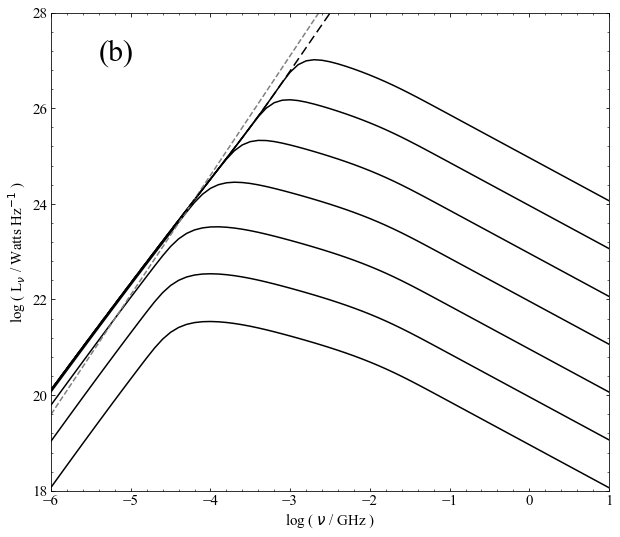

In [18]:
ax = pl.subplot(111)

em_nu0 = calc_em_synch(nu,H_G,N0)
kappa_nu0 = calc_kappa_synch(nu,H_G,N0)
    
for i in range(-10,-3):
    
    N1 = 5.*10.**(i)
    
    em_nu = em_nu0*N1/N0
    kappa_nu = kappa_nu0*N1/N0
    
    kappa = kappa_nu+kappa_ff
    tau_nu = kappa*dl
    i_nu = (em_nu/kappa)*(1 - np.exp(-1.*tau_nu))
    L_nu = i_nu*1e-3*4*np.pi*A_m2   # 1e-3 for: erg/s/cm^2/Hz --> Watts/m^2/Hz

    x = np.log10(nu[np.where(L_nu>0.)]/1e9)
    y = np.log10(L_nu[np.where(L_nu>0.)])
    pl.plot(x,y,c='black')
    
# add Longair approximate limit:
pl.plot(np.log10(nu/1e9), np.log10(L_abs), c='grey', ls="--")

# add exact limit:
pl.plot(np.log10(nu/1e9), np.log10(1e-3*4*np.pi*A_m2*em_nu0/kappa_nu0), c='black', ls="--", dashes=[6, 3])


pl.axis([-6,1,18,28])
pl.xlabel(r"log ( $\nu$ / GHz )",size=15)
pl.ylabel(r"log ( L$_{\nu}$ / Watts Hz$^{-1}$ )",size=15)
pl.locator_params(axis='x', nbins=8)
pl.locator_params(axis='y', nbins=5)
ax.tick_params(which="both",direction="in",top=True,right=True,labelsize=15)
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.set_aspect(0.6)

pl.text(-5.4,27,"(b)",size=30)

rcParams['figure.figsize'] = [10, 10]
pl.show()